### Train Multilayer Perceptron Network - XOR problem
https://lightning.ai/courses/deep-learning-fundamentals/training-multilayer-neural-networks-overview/4-3-training-a-multilayer-neural-network-in-pytorch-part-1-5/

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import tensor
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

#### Preprocess dataset

In [2]:
dataset = pd.read_csv('dataset/xor.csv')
dataset

,x1,x2,class label
0,0.781306,1.062984,0
1,-1.060524,-1.095550,0
2,0.632125,0.674028,0
3,-1.424712,0.535203,1
4,1.383161,1.368510,0
...,...,...,...
745,0.792484,0.839275,0
746,0.582466,-0.749250,1
747,-1.593475,0.671721,1
748,-0.812671,-0.268542,0


In [3]:
X = dataset[['x1', 'x2']].values
y = dataset['class label'].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=1, shuffle=True, stratify=y)

# pd.Series(y_train).value_counts()
# pd.Series(y_test).value_counts()

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=1, shuffle=True, stratify=y_train)

In [6]:
print(f"""
Training size: {X_train.shape}
Validation size: {X_val.shape}
Test size: {X_test.shape}
""")


Training size: (573, 2)
Validation size: (64, 2)
Test size: (113, 2)



#### Plot the dataset

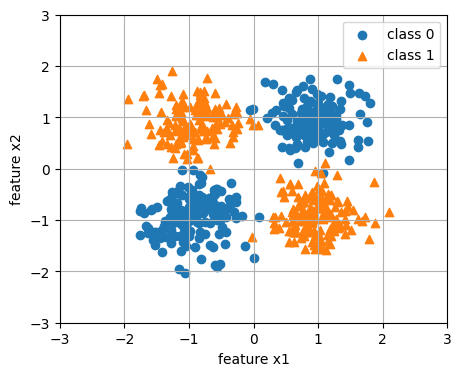

In [7]:
def plot_dataset():
    plt.figure(figsize=(5,4))
    plt.xlabel('feature x1')
    plt.ylabel('feature x2')

    plt.scatter(X_train[y_train==0,0], X_train[y_train==0,1], label='class 0', marker='o')
    plt.scatter(X_train[y_train==1,0], X_train[y_train==1,1], label='class 1', marker='^')

    plt.xlim([-3,3])
    plt.ylim([-3,3])
    plt.grid()
    plt.legend()
    plt.show()

plot_dataset()

#### Implement the Model

In [8]:
class MultilayerPerceptron(torch.nn.Module):

    def __init__(self, input_features, output_classes):
        super().__init__()

        # how to decide these number?
        layer1_outputs = 25
        layer2_outputs = 15

        # why 2 hidden layers? how to decide the number of layers?
        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(input_features, layer1_outputs),
            torch.nn.ReLU(),

            # 2nd hidden layer
            torch.nn.Linear(layer1_outputs, layer2_outputs),
            torch.nn.ReLU(),

            # output layer
            torch.nn.Linear(layer2_outputs, output_classes)
        )

    def forward(self, x):
        logits = self.all_layers(x)
        # why just return logits but not softmax? because cross_entropy does this for us
        return logits

#### Define dataset loader

In [15]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.features = tensor(X, dtype=torch.float32)
        self.labels = tensor(y, dtype=torch.int64) #?

    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]
        return x, y
    
    def __len__(self):
        return self.labels.shape[0]
    
train_dataset = MyDataset(X_train, y_train)
val_dataset = MyDataset(X_val, y_val)
test_dataset = MyDataset(X_test, y_test)

tensor([ 0.7806, -1.2019]) tensor(1)
tensor([-1.1680, -0.4318]) tensor(0)
tensor([-0.2623,  0.7828]) tensor(1)
tensor([-1.2533, -1.0640]) tensor(0)
tensor([0.4463, 1.5358]) tensor(0)
tensor([-0.7182,  1.7679]) tensor(1)
tensor([-0.9384, -0.9087]) tensor(0)
tensor([-0.6472,  0.7894]) tensor(1)
tensor([0.8925, 0.6836]) tensor(0)
tensor([ 0.9233, -0.6067]) tensor(1)
tensor([-0.7402,  0.5717]) tensor(1)
tensor([1.2099, 0.9718]) tensor(0)
tensor([ 1.1548, -1.4007]) tensor(1)
tensor([0.8907, 1.0779]) tensor(0)
tensor([-1.2816, -1.4485]) tensor(0)
tensor([-1.1063,  1.2115]) tensor(1)
tensor([ 1.0356, -0.7567]) tensor(1)
tensor([-0.5929,  1.1604]) tensor(1)
tensor([-1.0244,  0.1935]) tensor(1)
tensor([0.5917, 1.3372]) tensor(0)
tensor([-1.6384, -1.1505]) tensor(0)
tensor([-0.5765,  0.8785]) tensor(1)
tensor([ 1.0507, -0.0911]) tensor(1)
tensor([ 0.3236, -1.1774]) tensor(1)
tensor([-0.8120,  1.2864]) tensor(1)
tensor([-0.3236,  0.7210]) tensor(1)
tensor([ 2.0998, -0.8387]) tensor(1)
tensor([-1.

#### Training

In [10]:
def compute_accuracy(model, dataloader):
    correct = 0
    total_examples = 0 

    model = model.eval()
    for idx, (x_batch, y_batch) in enumerate(dataloader): # use dataloader in case dataset is large
        with torch.inference_mode(): # the same as torch.no_grad
            logits = model(x_batch)
        predictions = torch.argmax(logits, dim=1)
        compare = y_batch == predictions
        correct += torch.sum(compare)
        total_examples += len(compare)
    
    return correct / total_examples

In [11]:
def train(model, train_dataset, val_dataset, epochs, batch_size, learning_rate):
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    torch.manual_seed(1)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model = model.train()
        for idx, (x_batch, y_batch) in enumerate(train_loader):
            logits = model(x_batch)
            loss = F.cross_entropy(logits, y_batch)

            optimizer.zero_grad()
            loss.backward() # backpropagation
            optimizer.step() # update the model (weights)

            print(f"Epoch {epoch+1:03d}/{epochs:03d} - Batch {idx:03d}/{len(train_loader):03d} - Loss {loss:.2f}")
        
        train_acc = compute_accuracy(model, train_loader)
        val_acc = compute_accuracy(model, val_loader)
        print(f"Train Accuracy {train_acc*100:02f} - Val Accuracy {val_acc*100:02f}")

In [12]:
model = MultilayerPerceptron(2, 2)
train(model, train_dataset, val_dataset, epochs=10, batch_size=32, learning_rate=0.1)

Epoch 001/010 - Batch 000/018 - Loss 0.71
Epoch 001/010 - Batch 001/018 - Loss 0.70
Epoch 001/010 - Batch 002/018 - Loss 0.69
Epoch 001/010 - Batch 003/018 - Loss 0.69
Epoch 001/010 - Batch 004/018 - Loss 0.69
Epoch 001/010 - Batch 005/018 - Loss 0.69
Epoch 001/010 - Batch 006/018 - Loss 0.68
Epoch 001/010 - Batch 007/018 - Loss 0.67
Epoch 001/010 - Batch 008/018 - Loss 0.68
Epoch 001/010 - Batch 009/018 - Loss 0.67
Epoch 001/010 - Batch 010/018 - Loss 0.67
Epoch 001/010 - Batch 011/018 - Loss 0.66
Epoch 001/010 - Batch 012/018 - Loss 0.66
Epoch 001/010 - Batch 013/018 - Loss 0.66
Epoch 001/010 - Batch 014/018 - Loss 0.65
Epoch 001/010 - Batch 015/018 - Loss 0.66
Epoch 001/010 - Batch 016/018 - Loss 0.66
Epoch 001/010 - Batch 017/018 - Loss 0.64
Train Accuracy 94.240837 - Val Accuracy 98.437500
Epoch 002/010 - Batch 000/018 - Loss 0.63
Epoch 002/010 - Batch 001/018 - Loss 0.64
Epoch 002/010 - Batch 002/018 - Loss 0.63
Epoch 002/010 - Batch 003/018 - Loss 0.63
Epoch 002/010 - Batch 004/

#### Evaluation the model

In [13]:
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)
test_acc = compute_accuracy(model, test_loader)
print(f'Test acc {test_acc*100:02f}')

Test acc 100.000000
